In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import h5py
import collections
import scipy.sparse as sp_sparse
import tables
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks
import rpy2.robjects
from rpy2.robjects import pandas2ri


In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 4
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
# taking this out for now library(slingshot)
#library(monocle)
library(gam)
# library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

Load in the data

In [4]:
adataa = sc.read_10x_h5('/Users/vyom/data/SB10_SB11_results/Individual_Samples/SB10/Beyaz_10_10xgex_araasco/filtered_feature_bc_matrix.h5', genome=None, gex_only=True)
adataa.var_names_make_unique()

reading /Users/vyom/data/SB10_SB11_results/Individual_Samples/SB10/Beyaz_10_10xgex_araasco/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adatac = sc.read_10x_h5("/Users/vyom/data/SB10_SB11_results/Individual_Samples/SB10/Beyaz_10_10xgex_control/filtered_feature_bc_matrix.h5", genome=None, gex_only=True)
adatac.var_names_make_unique()


reading /Users/vyom/data/SB10_SB11_results/Individual_Samples/SB10/Beyaz_10_10xgex_control/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# merge datasets
adata1 = adatac.concatenate(adataa, batch_key='Sample', batch_categories=['Control','Araasco'])

In [7]:
# Checking the total size of the data set
adata1.shape

(15754, 32285)

In [8]:
#Filter genes that are not expressed in many cells(threshold min: 5):
print('Total number of genes: {:d}'.format(adata1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata1, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata1.n_vars))

Total number of genes: 32285
filtered out 16088 genes that are detected in less than 10 cells
Number of genes after cell filter: 16197


In [9]:
# Calculate normalized values for counts 
adata1.obs['n_counts'] = adata1.X.sum(1)
adata1.obs['log_counts'] = np.log(adata1.obs['n_counts'])
adata1.obs['n_genes'] = (adata1.X > 0).sum(1)

Identify number genes and counts and conduct log transformation of the counts

In [10]:
# filter cells that have produced less than 200 counts
sc.pp.filter_cells(adata1, min_counts=200)
# filter genes expressed in less than 3 cells
sc.pp.filter_genes(adata1, min_cells=3)

### Define gene sets for QC metrics

Cell stress increases variability and introduces bias. As a result, it is necessary to account for cells that are high in stress as their trancriptome would vary significanly from the viable sample thus skewing results. The proportion of mitochrondrial and ribosomal counts are metrics for cell stress. Cells with an elevated proportion of mitochrondrial and ribosomal counts are exempt from the sample.

In [11]:
# define mitochondrial and ribosomal genes
mito_genes = [name for name in adata1.var_names if name.startswith('mt-')]
Rpl_genes = [name for name in adata1.var_names if name.startswith('Rpl')]
Rps_genes = [name for name in adata1.var_names if name.startswith('Rps')]
ribo_genes = Rpl_genes + Rps_genes
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata1.obs['percent_mito'] = np.sum(
    adata1[:, mito_genes].X, axis=1) / np.sum(adata1.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata1.obs['n_counts'] = np.sum(adata1.X, axis=1)
#Count IEG genes and calculate percentage per cell
#adata.obs['percent_IEG'] = np.sum(
#    adata[:, IEG].X, axis=1) / np.sum(adata.X, axis=1)
#Calculate the percent Rpl genes per cell
adata1.obs['percent_Rpl'] = np.sum(
    adata1[:, Rpl_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent Ribo genes per cell
adata1.obs['percent_ribo'] = np.sum(
    adata1[:, ribo_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent cell cycle genes per cell
#adata.obs['percent_cell_cycle'] = np.sum(
#    adata[:, cell_cycle].X, axis=1) / np.sum(adata.X, axis=1)
#sc.tl.score_genes(adata,cell_cycle,score_name='cell_cycle')


# add the total counts per cell as observations-annotation to adata

... storing 'feature_types' as categorical
... storing 'genome' as categorical


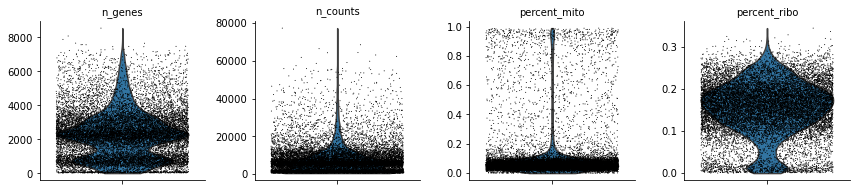

In [12]:
# identify proportions of stressed cells
axs = sc.pl.violin(adata1, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
                   jitter=0.4, multi_panel=True)

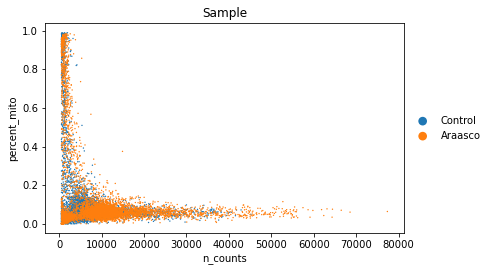

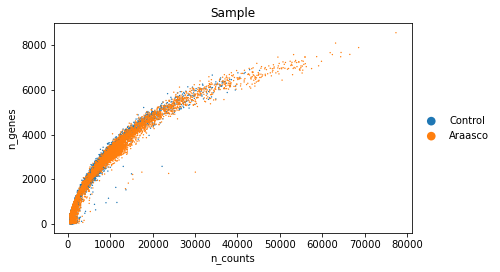

In [13]:
ax = sc.pl.scatter(adata1, x='n_counts', y='percent_mito', color='Sample')
ax = sc.pl.scatter(adata1, x='n_counts', y='n_genes', color='Sample')

In [14]:
# define cells to be exempt
n_gene_cap = 10000
n_counts_min = 4000
percent_mito_cap = 0.15

print("Cells with n_genes < " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] < n_gene_cap]))
print("Cells with n_genes > " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] > n_gene_cap]))
print()
print("Cells with n_counts_min < " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] < n_counts_min]))
print("Cells with n_counts_min > " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] > n_counts_min]))
print()
print("Cells with percent_mito < " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] < percent_mito_cap]))
print("Cells with percent_mito > " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] > percent_mito_cap]))

Cells with n_genes < 10000: 15754
Cells with n_genes > 10000: 0

Cells with n_counts_min < 4000: 5475
Cells with n_counts_min > 4000: 10279

Cells with percent_mito < 0.15: 14051
Cells with percent_mito > 0.15: 1703


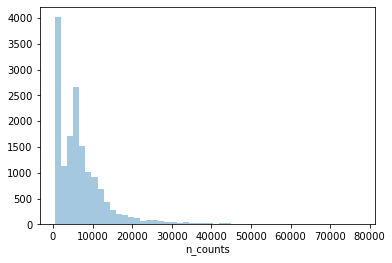

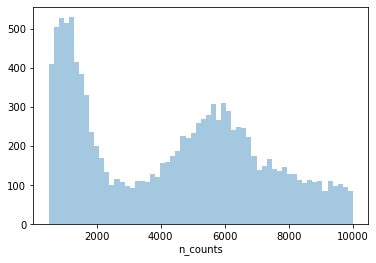

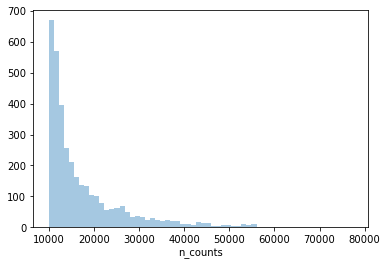

In [15]:
#Thresholding decision: counts
p3 = sb.distplot(adata1.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata1.obs['n_counts'][adata1.obs['n_counts']<10000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata1.obs['n_counts'][adata1.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

In [16]:
# filter cell sample
print("Number of cells before filtering:",len(adata1))
adata1 = adata1[adata1.obs['n_genes'] < n_gene_cap, :]
adata1 = adata1[adata1.obs['percent_mito'] < percent_mito_cap, :]
adata1 = adata1[adata1.obs['n_counts'] > n_counts_min, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 15754
Number of cells after filtering: 10010


In [17]:
# filter gene sample
print("Number of cells before filtering:",len(adata1))
#adata1 = adata1[adata1.obs['n_genes'] > 1000, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 10010
Number of cells after filtering: 10010


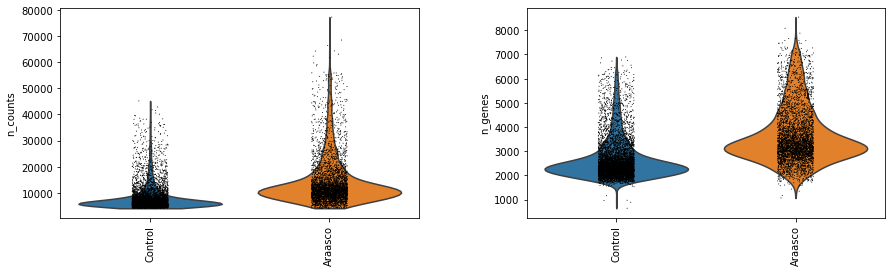

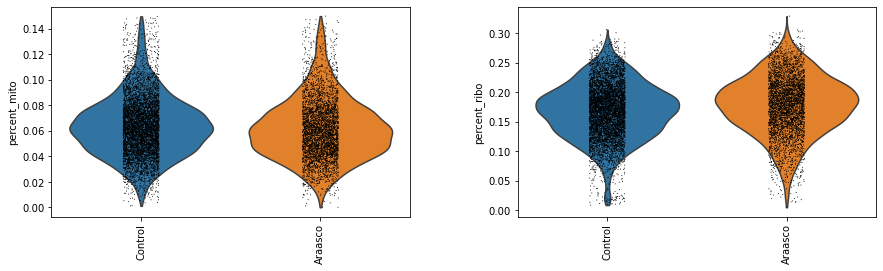

In [18]:
# view sample distributions to ensure filtering was accurate 
sc.pl.violin(adata1, groupby='Sample', keys=['n_counts','n_genes'], rotation=90)
sc.pl.violin(adata1, groupby='Sample', keys=['percent_mito','percent_ribo'], rotation=90)

In [19]:
# view dimensions of the annotated data matrix
adata1.shape

(10010, 16197)

In [20]:
#Perform a clustering for scran normalization in clusters
adata1_pp = adata1.copy()
sc.pp.normalize_per_cell(adata1_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata1_pp)
sc.pp.pca(adata1_pp, n_comps=15)
sc.pp.neighbors(adata1_pp)
sc.tl.louvain(adata1_pp, key_added='groups', resolution=0.7)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:08)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 15
    computed neighbors (0:00:05)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


Preprocess data by assuming that all size factors are equal

In [21]:
#Preprocess variables for scran normalization
%reload_ext rpy2.ipython
input_groups = adata1_pp.obs['groups']
data_mat = adata1.X.T

Calculate size factors

In [22]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups)

In [23]:
del adata1_pp

Visualize the estimated size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Trying to set attribute `.obs` of view, copying.


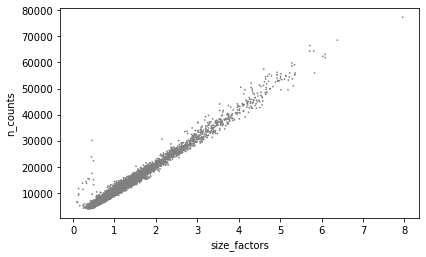

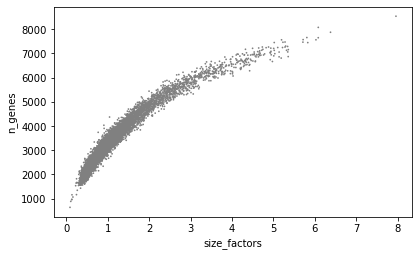

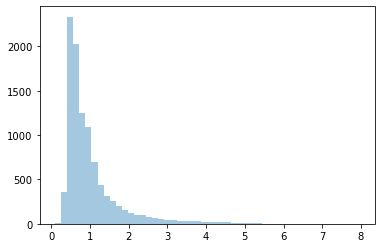

In [24]:

adata1.obs['size_factors'] = size_factors

sc.pl.scatter(adata1, 'size_factors', 'n_counts')
sc.pl.scatter(adata1, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

copy the raw count data in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [25]:
#Keep the count data in a counts layer
adata1.layers["counts"] = adata1.X.copy()

Log transform the data. This allows the log transformed data to follow or nearly follow a normal distribution and have reduced skewness

In [26]:
#Normalize adata 
adata1.X /= adata1.obs['size_factors'].values[:,None]
sc.pp.log1p(adata1)

In [27]:
del adata1.layers['counts']

In [28]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata1.raw = adata1

In [29]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata1_test = adata1.copy()
adata1_test.X = adata1.raw.X
adata1_test.obs['n_genes'] = (adata1_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [ ]:

%%R -i adata1_test -o ent_de1 

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata1_test, class = "SingleCellAssay")

#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)


#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca))
print("")

sca_ent_filt = sca[rowSums(assay(sca)) != 0, ]
#sca_ent_filt = sca[colData(sca)@listData$Sample == "AA", ]

print("Dimensions after subsetting:")
print(dim(sca_ent_filt))


#Define & run hurdle model - AA V Contr
zlmCond_ent <- zlm(formula = ~Sample + n_genes, sca=sca_ent_filt)
print('check1')
summaryCond_ent <- summary(zlmCond_ent, doLRT='SampleAraasco')
print('check2')
summaryDt_ent <- summaryCond_ent$datatable
print('check3')

result_ent <- merge(summaryDt_ent[contrast=='SampleAraasco' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_ent[contrast=='SampleAraasco' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients
print('check4')
#Correct for multiple testing (FDR correction) and filtering
result_ent[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
ent_de1 = result_ent[result_ent$FDR<0.01,, drop=F]
ent_de1 = ent_de1[order(ent_de1$FDR),]

/Users/vyom/opt/miniconda3/envs/scrna/lib/python3.8/site-packages/anndata2ri/py2r.py:37: NotConvertedWarning: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'
  warn(str(e), NotConvertedWarning)


[1] "Dimensions before subsetting:"
[1] 16197 10010
[1] ""
[1] "Dimensions after subsetting:"
[1] 16183 10010
[1] "check1"


In [ ]:
which anndata2ri

In [ ]:
print(ent_de1[:60])

In [ ]:
#Volcano plot of results
ent_de1['-logQ'] = -np.log(ent_de1['FDR'])
lowqval_de = ent_de1.loc[ent_de1['-logQ'] > 200]
other_de = ent_de1.loc[ent_de1['-logQ'] < 200]

fig, ax = plt.subplots()
sb.regplot(other_de['coef'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
sb.regplot(lowqval_de['coef'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':6})
ax.set_xlabel("log2 FC", fontsize=20)
ax.set_ylabel("-log Q-value", fontsize=20)
ax.tick_params(labelsize=15)

# Label names and positions
x = [i-0.2 for i in lowqval_de['coef']]
y = [i+10 for i in lowqval_de['-logQ']]
labels = lowqval_de['primerid']

# Show only some labels to avoid overcrowding the figure
to_remove = np.where([i < 230 for i in y])[0]
labels = ["" if i in to_remove else lab for i,lab in enumerate(labels) ]

#Move up two labels
y = [y[i]+10 if txt == 'Krt8' else y[i] for i,txt in enumerate(labels)]
y = [y[i]+20 if txt == 'Cd9' else y[i] for i,txt in enumerate(labels)]

#Move down one label
y = [y[i]-20 if txt == 'Phgr1' else y[i] for i,txt in enumerate(labels)]

for i,txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

In [ ]:
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

paneth_enrichment = gp.profile(organism='mmusculus', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               background=adata1.var_names.tolist(), 
                               query=ent_de1['primerid'].tolist())

In [ ]:
adata1.shape

In [ ]:
adata1.obs

In [ ]:

#paneth_enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
paneth_enrich_results = paneth_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [ ]:
pd.set_option("display.max_colwidth", 800)
paneth_enrich_results.iloc[:50,:]

In [ ]:
def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)
def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()
    

plot_enrich(paneth_enrich_results)